# Fuzzing
Fuzzing is a software testing technique in which the goal is to automatically feed a given program with a sequence of randomly generated inputs in order to find errors or inadequate behaviors in its execution. The generation of inputs is made by a program called a Fuzzer, which usually strives to create data that is valid enough to be accepted by the test subject while also hitting some obscure edge-case the developers had never thought of. This technique is also very useful for discovering security vulnerabilities in a given system since the random inputs might trigger some exploitable behavior such as a buffer overflows or DoS. <br/>
In the following short video we can see a bit more about the effectiveness of this technique and how it came to be.

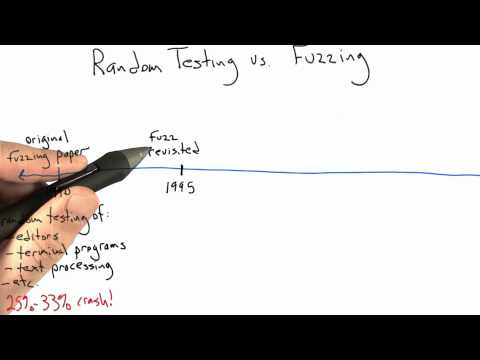

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('RqrHT93KdgE')

## Hands on with pythonfuzz
The fuzzer known as [*pythonfuzz*](https://gitlab.com/gitlab-org/security-products/analyzers/fuzzers/pythonfuzz) is a simple yet powerful example of what a fuzzer can do. In essence, all it does is receive a function which will be called infinitely with different randomly generated inputs each time until it eventually finds an unexpected exception. <br/>
First things first, let's install it:

In [2]:
pip install pythonfuzz

Note: you may need to restart the kernel to use updated packages.


### Defining a test subject
For this example, let's test the parsing method in Python's built-in html module. <br/>
In order for the test to work, we'll need to create a function that:
1. Is annotated with the `@PythonFuzz` annotation in order to be ran in a loop and receive the randomized parameters.
2. Receives an array of bytes as its only parameter and converts it to the format that the test subjects accepts as input.
3. Calls the test subject with the converted input.
4. Catches and ignores any expected exceptions that might appear in runtime.

Note that in the last point we state that some exceptions should be intentionally ignored. This is because they might actually be the correct and expected behavior of the tested code or even thrown by our byte array parser itself. In the following example we'll try to decode random byte arrays into ascii strings, an operation that will oftentimes fail and, as such, we should just ignore it and continue to the next input.
## Example

In [3]:
# Cleaning sys.argv for compatibility with Jupyter-Notebook
# This should be unnecessary in a vanilla Python environment
import sys
sys.argv = ['']

In [4]:
from html.parser import HTMLParser
from pythonfuzz.main import PythonFuzz

@PythonFuzz
def fuzz(buf):
    try:
        string = buf.decode("ascii")
        parser = HTMLParser()
        parser.feed(string)
    except UnicodeDecodeError:
        pass

# This `if` statement is here to prevent a possible long execution from happening everytime this book is built
# Just consider that we are calling the fuzz function normally
if 0:
    fuzz()
    

#0 READ units: 0
#1 NEW     cov: 0 corp: 1 exec/s: 18 rss: 112.484375 MB
#2 NEW     cov: 51 corp: 2 exec/s: 703 rss: 112.48828125 MB
#20 NEW     cov: 77 corp: 3 exec/s: 3169 rss: 112.48828125 MB
#434 NEW     cov: 101 corp: 4 exec/s: 3473 rss: 112.48828125 MB
#435 NEW     cov: 429 corp: 5 exec/s: 1146 rss: 112.48828125 MB
#455 NEW     cov: 430 corp: 6 exec/s: 3295 rss: 112.48828125 MB
#1228 NEW     cov: 438 corp: 7 exec/s: 3246 rss: 112.48828125 MB
#1344 NEW     cov: 455 corp: 8 exec/s: 3172 rss: 112.48828125 MB
#1358 NEW     cov: 456 corp: 9 exec/s: 2850 rss: 112.48828125 MB
#1521 NEW     cov: 476 corp: 10 exec/s: 3168 rss: 112.48828125 MB
#3163 NEW     cov: 480 corp: 11 exec/s: 3207 rss: 112.48828125 MB
#3168 NEW     cov: 482 corp: 12 exec/s: 1956 rss: 112.55859375 MB
#11320 NEW     cov: 504 corp: 13 exec/s: 3116 rss: 112.5625 MB
#18950 NEW     cov: 519 corp: 14 exec/s: 3157 rss: 112.5625 MB
#20553 NEW     cov: 527 corp: 15 exec/s: 3218 rss: 112.5625 MB
#29763 NEW     cov: 535 corp: 1

### Results
Given enough time, hopefully the previous code snippet should be able to find an unhandled exception in the html parser, usually the `NotImplementedError: subclasses of ParserBase must override error()`.
It will also conveniently save the error-causing input in a file which name it states in the end of its execution so that we can see it and analyze the exception cause. The file's content will be an array of bytes, so you might want to convert it to your intended format before analyzing. <br/>

In our execution's case, pythonfuzz said that the input that caused an error was `<![!>`. Let's check if that holds true.

In [5]:
parser = HTMLParser()
parser.feed('<![!>')

NotImplementedError: subclasses of ParserBase must override error()

In fact, it seems like this input really breaks the html parser. <br/>
Now, what about using it to test our own programs? Well, we can apply the same principles as before. For the next example, let's create a hypothetical function that receives an integer but raises an exception when this integer is 74.

In [6]:
def intFunc(integer):
    if integer == 74:
        raise Exception('oh no')
    else:
        return "ok"

@PythonFuzz
def fuzz2(buf):
    try:
        integer = int.from_bytes(buf, "big")  
        intFunc(integer)

    except SyntaxError:
        pass


fuzz2()

#0 READ units: 0
#1 NEW     cov: 0 corp: 1 exec/s: 107 rss: 113.54296875 MB
#2 NEW     cov: 29 corp: 2 exec/s: 960 rss: 113.59375 MB
#28880 PULSE     cov: 55 corp: 3 exec/s: 5775 rss: 113.59375 MB
oh no
Traceback (most recent call last):
  File "/home/claudio/.local/lib/python3.8/site-packages/pythonfuzz/fuzzer.py", line 24, in worker
    target(buf)
  File "<ipython-input-6-1259eb7f2e89>", line 11, in fuzz2
    intFunc(integer)
  File "<ipython-input-6-1259eb7f2e89>", line 3, in intFunc
    raise Exception('oh no')
Exception: oh no
crash was written to crash-6da43b944e494e885e69af021f93c6d9331c78aa228084711429160a5bbd15b5
crash = 4a


Note that in this case we also used the `try/except` block to pass when finding a `SyntaxError`. This is because not all byte arrays can be converted to integers and we wouldn't want the fuzzer to stop its execution because of that, so it must just move on to the next input and try again.

### Conclusion
As seen in our example, fuzzers are very easy to use and even develop. I encourage you to take a look into pythonfuzz's repository and see how simple the implementation really is. You might even be able to contribute since it is open-source! This technique is also quite powerful, as it can find edge-cases that a human mind would hardly have even thought of. <br/>
If you want to learn more deeply about fuzzing, I highly recommend you to read the spectacular [Fuzzing Book](https://www.fuzzingbook.org/) by Andreas Zeller, Rahul Gopinath, Marcel Böhme, Gordon Fraser, and Christian Holler. It really enters in detail about every single aspect of this technique and is an accessible read even for beginner programmers.

## References
1. https://en.wikipedia.org/wiki/Fuzzing
2. https://www.fuzzingbook.org/
3. https://owasp.org/www-community/Fuzzing
4. http://www.squarefree.com/categories/fuzzing/
5. https://gitlab.com/gitlab-org/security-products/analyzers/fuzzers/pythonfuzz